In [175]:
import numpy as np
from scipy import stats
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
%matplotlib inline
# %matplotlib notebook 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
from sympy.utilities.codegen import codegen
init_printing(use_latex=True)

# Extended Kalman Filter Implementation for CTRV Vehicle Model in Python

### Adapted from - https://github.com/balzer82/Kalman/blob/master/Extended-Kalman-Filter-CTRV.ipynb

## State Vector - Constant Turn Rate and Velocity Vehicle Model (CTRV)

**Situation covered**: You have a velocity sensor, which measures the vehicle speed ($v$) in forwarding direction, and a yaw rate sensor ($\dot \psi$) which both have to fused with the position ($x$ & $y$) from a GPS sensor.

![](CTRV-Model.png)

$$ x_k= \begin{bmatrix} x \\ y \\ \psi \\ v \\ \dot\psi \end{bmatrix} = \begin{bmatrix} \text{Position X} \\ \text{Position Y} \\ \text{Heading} \\ \text{Velocity} \\ \text{Yaw Rate} \end{bmatrix} $$


## System Dynamics

In [176]:
numstates=5 # States

All symbolic calculations are made with [Sympy](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-5-Sympy.ipynb). Thanks!

In [177]:
vs, psis, dpsis, dts, xs, ys, lats, lons = symbols('v \psi \dot\psi T x y lat lon')

### State vector

In [178]:
state = Matrix([xs,ys,psis,vs,dpsis])
state

⎡   x    ⎤
⎢        ⎥
⎢   y    ⎥
⎢        ⎥
⎢  \psi  ⎥
⎢        ⎥
⎢   v    ⎥
⎢        ⎥
⎣\dot\psi⎦

### Process vector function f

These formulas calculate how the state is evolving from one to the next time step

In [179]:
fs = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+(vs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))],
             [psis+dpsis*dts],
             [vs],
             [dpsis]])
fs

⎡    v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))⎤
⎢x + ───────────────────────────────────────⎥
⎢                    \dot\psi               ⎥
⎢                                           ⎥
⎢    v⋅(cos(\psi) - cos(T⋅\dot\psi + \psi)) ⎥
⎢y + ────────────────────────────────────── ⎥
⎢                   \dot\psi                ⎥
⎢                                           ⎥
⎢             T⋅\dot\psi + \psi             ⎥
⎢                                           ⎥
⎢                     v                     ⎥
⎢                                           ⎥
⎣                 \dot\psi                  ⎦

### Calculate the Jacobian matrix $J_F$ with respect to the state vector

Matrix $J_F$ is the Jacobian of the Process function $f$ with respect to the state. Function $f$ is used to compute the predicted state vector from the previous estimated state vector.

In [180]:
fs.jacobian(state)

⎡      v⋅(-cos(\psi) + cos(T⋅\dot\psi + \psi))  -sin(\psi) + sin(T⋅\dot\psi + 
⎢1  0  ───────────────────────────────────────  ──────────────────────────────
⎢                      \dot\psi                               \dot\psi        
⎢                                                                             
⎢                                                                             
⎢      v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))  cos(\psi) - cos(T⋅\dot\psi + \
⎢0  1  ───────────────────────────────────────  ──────────────────────────────
⎢                      \dot\psi                              \dot\psi         
⎢                                                                             
⎢                                                                             
⎢0  0                     1                                      0            
⎢                                                                             
⎢0  0                     0                         

It has to be computed on every filter step because it consists of state variables!

To Sympy Team: A `.to_python` and `.to_c` and `.to_matlab` whould be nice to generate code, like it already works with `print latex()`.

## Initial Uncertainty $P_0$

Initialized with $0$ means you are pretty sure where the vehicle starts

In [181]:
P = np.diag([10.0, 10.0, 10.0, 10.0, 10.0])
print(P, P.shape)

[[10.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.]
 [ 0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0. 10.]] (5, 5)


## Process Noise Covariance Matrix Q

"*The state uncertainty model models the disturbances which excite the linear system. Conceptually, it estimates how bad things can get when the system is run open loop for a given period of time.*" - Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May). Retrieved from http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA282853

In [182]:
dt = 1.0/50.0 # Sample Rate of CAN is 50 Hz (MY_VELOCITY.csv and MY_YAWRATE.csv)
dtGPS = 1.0/5.0 # Sample Rate of Low Cost GPS is 5 Hz (MY_NAV-POSLLH.csv)

In [183]:
# Standard deviations
#sGPS     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
sGPS     = 0.5*2.0*dt**2  # assume 2.0m/s2 as maximum acceleration, conforme o artigo do Chemnitz
print("sGPS: ", sGPS)

#sCourse  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
sCourse  = 0.01*dt # assume 0.01rad/s as yawrate bias
print("sCourse: ", sCourse)

sVelocity= 8.8*dt  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
sVelocity= 2.0*dt  # assume 2.0m/s2 as maximum acceleration, conforme o artigo do Chemnitz
print("sVelocity: ", sVelocity)

sYawrate = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle
sYawrate = 0.2*dt # assume 0.2rad/s2 as angular acceleration, conforme o artigo do Chemnitz
print("sYawrate: ", sYawrate)

Q = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2, sYawrate**2])
#Q = np.diag([0.01, 0.01, 0.01, 0.01, 0.01])

print(Q, Q.shape)


sGPS:  0.0004
sCourse:  0.0002
sVelocity:  0.04
sYawrate:  0.004
[[1.6e-07 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.6e-07 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 4.0e-08 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 1.6e-03 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.6e-05]] (5, 5)


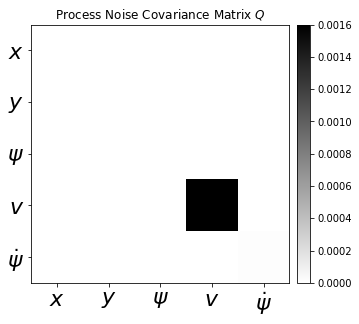

In [184]:
fig = plt.figure(figsize=(5, 5))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(8))
# set the locations and labels of the yticks
plt.yticks(np.arange(7),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(8))
# set the locations and labels of the yticks
plt.xticks(np.arange(7),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5,4.5])
plt.ylim([4.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

## Measurement System

## Measurement Function h

Matrix $J_H$ is the Jacobian of the Measurement function $h$ with respect to the state. Function $h$ can be used to compute the predicted measurement from the predicted state.

If a GPS measurement is available, the following function maps the state to the measurement.

In [185]:
hs = Matrix([[xs],
             [ys],
             [vs],
             [dpsis]])
hs

⎡   x    ⎤
⎢        ⎥
⎢   y    ⎥
⎢        ⎥
⎢   v    ⎥
⎢        ⎥
⎣\dot\psi⎦

In [186]:
JHs=hs.jacobian(state)
JHs

⎡1  0  0  0  0⎤
⎢             ⎥
⎢0  1  0  0  0⎥
⎢             ⎥
⎢0  0  0  1  0⎥
⎢             ⎥
⎣0  0  0  0  1⎦

If no GPS measurement is available, simply set the corresponding values in $J_h$ to zero.

## Measurement Noise Covariance $R$

"In practical use, the uncertainty estimates take on the significance of relative weights of state estimates and measurements. So it is not so much important that uncertainty is absolutely correct as it is that it be relatively consistent across all models" - Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May). Retrieved from http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA282853

In [187]:
# Measurement Standard Deviations
#msdGPS = 5.0 # Standard Deviation of GPS Measurement
msdGPS = 4.11 # Devio padrão da distância euclidiana entre medição e GT
msdGPS = 4 # Devio padrão da distância euclidiana entre medição e GT

#msdSpeed = 3.0 # Standard Deviation of the speed measurement
#msdSpeed = 2.11 # Devio padrão do parâmetro: Velocity (GT Velocity) [m/s]
#msdSpeed = 0.05 # Desvio padrão na velocidade entre CAN e GT
msdSpeed = 0.2 # Erro máximo na velocidade entre CAN e GT

#msdYawrate = 0.1 # Standard Deviation of the yawrate measurement
#msdYawrate = 0.15 # Devio padrão do parâmetro: Yaw-Rate (GT Yaw-rate) [rad/s]
#msdYawrate = 0.02 # Desvio padrão no yawrate entre CAN e GT
msdYawrate = 0.05 # Erro máximo no yawrate entre CAN e GT

R = np.diag([msdGPS**2, msdGPS**2, msdSpeed**2, msdYawrate**2])
#R = np.diag([100.0, 100.0, 10.0, msdYawrate**2])

print(R, R.shape)

[[1.6e+01 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.6e+01 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 4.0e-02 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 2.5e-03]] (4, 4)


In [188]:
# Relação entre elementos das matrizes R e Q
print(R[2,2]/Q[3,3], R[3,3]/Q[4,4])

25.000000000000004 156.25000000000003


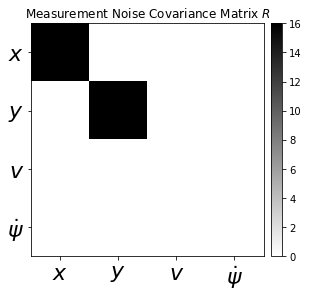

In [189]:
fig = plt.figure(figsize=(4.5, 4.5))
im = plt.imshow(R, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Measurement Noise Covariance Matrix $R$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(5))
# set the locations and labels of the yticks
plt.yticks(np.arange(4),('$x$', '$y$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(5))
# set the locations and labels of the yticks
plt.xticks(np.arange(4),('$x$', '$y$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5, 3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

## Identity Matrix

In [190]:
I = np.eye(numstates)
print(I, I.shape)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]] (5, 5)


## Loading real measurements

In [191]:
import pandas as pd

# MY_DATASET_CTRV contains synchronized data from NAV-POSLLH (latitude, longitude, Height above ellipsoid and heading), VELOCITY (velocity) and YAWRATE (yawrate)
df1 = "MY_DATASET.csv"
df1 = pd.read_csv(df1, sep=',')
df1

,GPSWeek [weeks],GPSSecondsOfWeek [s],Longitude (lon) [deg],Latitude (lat) [deg],Height above ellipsoid (height) [m],Longitude (GT Lon) [deg],Latitude (GT Lat) [deg],Height above ellipsoid (GT Height) [m],"Heading (0° = East, counterclockwise) - (GT Heading) [rad]",Acceleration (GT Acceleration) [ms^2],GPSSecondsOfWeek [s] - Velocity,Velocity [meter/second],GPSSecondsOfWeek [s] - Yawrate,Yaw-Rate [rad/s]
0,1900.0,126642.0,13.373692,52.504600,80.236,13.373671,52.504585,76.020936,1.243817,0.645004,126642.00,6.077778,126642.00,-0.016930
1,1900.0,126642.2,13.373697,52.504610,80.233,13.373676,52.504595,76.027829,1.240403,0.566129,126642.02,6.083333,126642.02,-0.016232
2,1900.0,126642.2,13.373697,52.504610,80.233,13.373676,52.504595,76.027829,1.240403,0.566129,126642.04,6.111111,126642.04,-0.016057
3,1900.0,126642.2,13.373697,52.504610,80.233,13.373676,52.504595,76.027829,1.240403,0.566129,126642.06,6.127778,126642.06,-0.014486
4,1900.0,126642.2,13.373697,52.504610,80.233,13.373676,52.504595,76.027829,1.240403,0.566129,126642.08,6.127778,126642.08,-0.015708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14126,1900.0,126924.7,13.373559,52.504508,80.125,13.373564,52.504490,77.886868,-2.090978,-1.057214,126924.53,5.105556,126924.53,-0.060039
14127,1900.0,126924.7,13.373559,52.504508,80.125,13.373564,52.504490,77.886868,-2.090978,-1.057214,126924.55,5.069444,126924.55,-0.063705
14128,1900.0,126924.7,13.373559,52.504508,80.125,13.373564,52.504490,77.886868,-2.090978,-1.057214,126924.57,5.041667,126924.57,-0.066323
14129,1900.0,126924.7,13.373559,52.504508,80.125,13.373564,52.504490,77.886868,-2.090978,-1.057214,126924.59,5.022222,126924.59,-0.069813


In [192]:
latitude = df1['Latitude (lat) [deg]']
longitude = df1['Longitude (lon) [deg]']
altitude = df1['Height above ellipsoid (height) [m]']
latitudeGT = df1['Latitude (GT Lat) [deg]']
longitudeGT = df1['Longitude (GT Lon) [deg]']
altitudeGT = df1['Height above ellipsoid (GT Height) [m]']
course = df1['Heading (0° = East, counterclockwise) - (GT Heading) [rad]']
speed = df1['Velocity [meter/second]']
yawrate = df1['Yaw-Rate [rad/s]']

# Pegar os timestamps das medições para utilizar na fusão do EKF
gps_time = df1['GPSSecondsOfWeek [s]']
imu_time = df1['GPSSecondsOfWeek [s] - Velocity']

In [193]:
# Somente visualizações de valores e testes
# Agrupar pos GPSSecondsOfWeek
# list_1 = df1.groupby(by=["GPSSecondsOfWeek [s]"]).count()
# list_1

#list_1["GPSWeek [weeks]"].idxmax()
#list_1["GPSWeek [weeks]"].loc[[126643.3]]
#df1["GPSSecondsOfWeek [s]"][df1["GPSSecondsOfWeek [s]"] == 126643.3]

# from scipy import stats
# stats.describe(list_1["GPSWeek [weeks]"])


In [194]:
# Somente visualizações de valores e testes
# gps_time, imu_time
# gps_time.shape, imu_time.shape
# teste=(imu_time>=gps_time).astype('bool')
# teste[13800:-1]

In [195]:
# Somente visualizações de valores e testes
# from scipy import stats

# check_yawrate = (np.abs(yawrate) < 0.0001)
# print(check_yawrate)

# (unique, counts) = np.unique(check_yawrate, return_counts=True)
# unique, counts

# #stats.describe(check_yawrate)

# # result = df1['Yaw-Rate [rad/s]'].loc[df1['Yaw-Rate [rad/s]'] < 0.0001]
# # print(result)


## Measurement Units

**Lat/Lon** in decimal degree (from GT and GPS)  
**Course** in radian degree (from GT)  
**Speed** in m/s (from CAN)  
**Roll-/Pitch-/Yawrate** in radians/second (from CAN)

## Approx. Lat/Lon to Meters to check Location

In [196]:
# Calculating position using data from GPS and GT (Ground Truth)
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°
arcGT= 2.0*np.pi*(RadiusEarth+altitudeGT)/360.0 # m/°

# Equirectangular projection (https://en.wikipedia.org/wiki/Equirectangular_projection)
# x = r * cos(latitude)*(longitude_{K} - longitude_{K-1})
# y = r * (latitude_{K} - latitude_{K-1})
dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

dxGT = arcGT * np.cos(latitudeGT*np.pi/180.0) * np.hstack((0.0, np.diff(longitudeGT))) # in m
dyGT = arcGT * np.hstack((0.0, np.diff(latitudeGT))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)
mxGT = np.cumsum(dxGT)
myGT = np.cumsum(dyGT)

# ds = np.sqrt(dx**2+dy**2)
# GPS=(ds!=0.0).astype('bool') # GPS Trigger for Kalman Filter

GPS=(imu_time >= gps_time).astype('bool')

In [197]:
# Somente visualizações de valores e testes
# import numpy as np
# from scipy import stats

# stats.describe(GPS)

# i = 0
# f = -1
# #print(GPS[i:f], GPS2[i:f])
# print(imu_time[i:f])
# print(gps_time[i:f])
# GPS2=(imu_time >= gps_time).astype('bool')
# print(GPS2[i:f])

## Initial State

[[ 0.        ]
 [ 0.        ]
 [ 1.24381734]
 [ 6.07777778]
 [-0.01692969]] (5, 1)


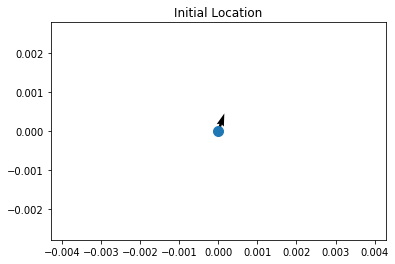

In [198]:
# course in radians, yawrate in radians/s, and speed in m/s
x = np.matrix([[mx[0], my[0], course[0], speed[0], yawrate[0]]]).T
print(x, x.shape)

U=float(np.cos(x[2])*x[3])
V=float(np.sin(x[2])*x[3])

# quiver plots a 2D field of arrows. X, Y define the arrow locations, U, V define the arrow directions.
plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

### Put everything together as a measurement vector

In [199]:
measurements = np.vstack((mx, my, speed, yawrate))
# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(4, 14131)


In [200]:
# Preallocation for Plotting
x0     = []
x1     = []
x2     = []
x3     = []
x4     = []
Zx     = []
Zy     = []
Px     = []
Py     = []
Ppsi   = []
Pv     = []
Pdpsi  = []
Kx     = []
Ky     = []
Kpsi   = []
Kv     = []
Kdpsi  = [] 
dstate = []

In [201]:
# Para a plotagem da distância euclidiana
x0p    = [0]
x1p    = [0]
mxp    = [0]
myp    = [0]
mxGTp  = [0]
myGTp  = [0]
innov_x= []
innov_y= []

# Extended Kalman Filter

![Extended Kalman Filter Step](ExtendedKalmanFilterAlgorithm.png)

$$x_k= \begin{bmatrix} x \\ y \\ \psi \\ v \\ \dot\psi \end{bmatrix} = \begin{bmatrix} \text{Position X} \\ \text{Position Y} \\ \text{Heading} \\ \text{Velocity} \\ \text{Yaw Rate} \end{bmatrix} =  \underbrace{\begin{matrix}x[0] \\ x[1] \\ x[2] \\ x[3] \\ x[4]  \end{matrix}}_{\textrm{Python Nomenclature}}$$

In [202]:
### Realização de alguns testes ###

# filterstep = 0
# JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0],
#                     [0.0, 1.0, 0.0, 0.0, 0.0],
#                     [0.0, 0.0, 0.0, 1.0, 0.0],
#                     [0.0, 0.0, 0.0, 0.0, 1.0]])
# JH.shape[0],1
# # #Z = np.append(measurements_1[:,filterstep], measurements_2[:,filterstep]).reshape(JH.shape[0],1)
# # # Z = measurements_1[:,filterstep]
# # # for i in measurements_2[:,filterstep]:
# # #     Z.concatenate(i, axis=0)
# # Z
# Z = measurements[:,filterstep].reshape(JH.shape[0],1)
# Z


In [203]:
# hdg1 = (x[2] + x[4]*dt + np.pi) % (2.0*np.pi) - np.pi
# hdg2 = x[2] + x[4]*dt
# x[2], hdg1, hdg2

In [204]:
for filterstep in range(m):

    # ========================
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "System Dynamics"
    if np.abs(yawrate[filterstep])<0.0001: # Driving straight
        x[0] = x[0] + x[3]*dt * np.cos(x[2]) # Updating position x
        x[1] = x[1] + x[3]*dt * np.sin(x[2]) # Updating position y
        x[2] = x[2] # Updating heading
        x[3] = x[3] # Updating velocity
        x[4] = 0.0000001 # avoid numerical issues in Jacobians
        dstate.append(0)
    else: # otherwise
        x[0] = x[0] + (x[3]/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2])) # Updating position x
        x[1] = x[1] + (x[3]/x[4]) * (-np.cos(x[4]*dt+x[2]) + np.cos(x[2])) # Updating position y
        ### Checar esta atualização do heading
        ### x[2] = x[2] + x[4]*dt # Updating heading
        x[2] = (x[2] + x[4]*dt + np.pi) % (2.0*np.pi) - np.pi # Updating heading
        x[3] = x[3] # Updating velocity
        x[4] = x[4] # Constant Turn Rate
        dstate.append(1)
    
    # Calculate the Jacobian of the process vector function f
    # see "Calculate the Jacobian matrix JF with respect to the state vector"
    a13 = float((x[3]/x[4]) * (np.cos(x[4]*dt+x[2]) - np.cos(x[2])))
    a14 = float((1.0/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    a15 = float((dt*x[3]/x[4])*np.cos(x[4]*dt+x[2]) - (x[3]/x[4]**2)*(np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    a23 = float((x[3]/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    a24 = float((1.0/x[4]) * (-np.cos(x[4]*dt+x[2]) + np.cos(x[2])))
    a25 = float((dt*x[3]/x[4])*np.sin(x[4]*dt+x[2]) - (x[3]/x[4]**2)*(-np.cos(x[4]*dt+x[2]) + np.cos(x[2])))
    JF = np.matrix([[1.0, 0.0, a13, a14, a15],
                    [0.0, 1.0, a23, a24, a25],
                    [0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 1.0]])
    
    # Project the error covariance ahead
    P = JF*P*JF.T + Q
    
    
    
    # ===============================
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[3])],
                    [float(x[4])]])

    # GPS 5Hz, IMU 50Hz ===> 10 IMU to 1 GPS measurement
    if GPS[filterstep]: 
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0]])
    else: # every other step
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0]])        
    
    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = Z - (hx)                         # Innovation or Residual
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*JH))*P

    if GPS[filterstep]:
        x0p.append(float(x[0]))
        x1p.append(float(x[1]))
        mxp.append(mx[filterstep])
        myp.append(my[filterstep])
        mxGTp.append(mxGT[filterstep])
        myGTp.append(myGT[filterstep])
        
    # ===============================
    # Save states for Plotting
    # ===============================
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    
    # Innovation
    innov_x.append(y[0,0])
    innov_y.append(y[1,0])
    
    # Covariance
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Ppsi.append(float(P[2,2]))
    Pv.append(float(P[3,3]))
    Pdpsi.append(float(P[4,4]))
    
    # Kalman gain
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kpsi.append(float(K[2,0]))
    Kv.append(float(K[3,0]))
    Kdpsi.append(float(K[4,0]))    

In [205]:
pos_x = np.asarray(x0p)
pos_y = np.asarray(x1p)
pos_mx = np.asarray(mxp)
pos_my = np.asarray(myp)
pos_mxGT = np.asarray(mxGTp)
pos_myGT = np.asarray(myGTp)
print(pos_x, pos_x.shape)
print(pos_y, pos_y.shape)
print(pos_mx, pos_mx.shape)
print(pos_my, pos_my.shape)
print(pos_mxGT, pos_mxGT.shape)
print(pos_myGT, pos_myGT.shape)


[ 0.          0.02403774  0.40346799 ... -6.77064998 -7.2677951
 -7.75632402] (1372,)
[ 0.          0.07083595  1.20797462 ... -7.75455458 -8.72766086
 -9.65810709] (1372,)
[ 0.          0.          0.37269884 ... -7.56841999 -8.083423
 -8.5374389 ] (1372,)
[ 0.          0.          1.13551777 ... -7.29117504 -8.27083742
 -9.26163231] (1372,)
[ 0.          0.          0.3707303  ... -5.76513761 -6.25888887
 -6.7424675 ] (1372,)
[ 0.          0.          1.12806873 ... -7.82749284 -8.79208223
 -9.71263962] (1372,)


In [206]:
import pandas as pd
results = pd.DataFrame(list(zip(x0, mx, x1, my, x2, course, x3, speed, x4, yawrate)),
               columns =['x_est', 'x', 'y_est', 'y', 'heading_est', 'heading', 'velocity_est', 'velocity', 'yawrate_est', 'yawrate'])
results.head(20)

,x_est,x,y_est,y,heading_est,heading,velocity_est,velocity,yawrate_est,yawrate
0,0.024038,0.000000,0.070836,0.000000,1.243477,1.243817,6.077774,6.077778,-0.016930,-0.016930
1,0.063165,0.372699,0.186015,1.135518,1.243152,1.240403,6.080603,6.083333,-0.016580,-0.016232
2,0.102483,0.372699,0.301636,1.135518,1.242831,1.240403,6.091414,6.111111,-0.016404,-0.016057
3,0.141937,0.372699,0.417556,1.135518,1.242541,1.240403,6.101698,6.127778,-0.015914,-0.014486
4,0.181442,0.372699,0.533494,1.135518,1.242227,1.240403,6.108063,6.127778,-0.015871,-0.015708
5,0.221064,0.372699,0.649662,1.135518,1.241919,1.240403,6.115496,6.141667,-0.015781,-0.015359
6,0.260867,0.372699,0.766242,1.135518,1.241608,1.240403,6.126094,6.166667,-0.015742,-0.015533
7,0.300706,0.372699,0.882788,1.135518,1.241284,1.240403,6.133583,6.163889,-0.015810,-0.016232
8,0.340676,0.372699,0.999609,1.135518,1.240970,1.240403,6.142618,6.180556,-0.015797,-0.015708
9,0.380792,0.372699,1.116753,1.135518,1.240662,1.240403,6.153436,6.200000,-0.015746,-0.015359


In [207]:
dstate_array = np.array(dstate)
dstate_array

array([1, 1, 1, ..., 1, 1, 1])

In [208]:
from scipy import stats

stats.describe(dstate_array)

DescribeResult(nobs=14131, minmax=(0, 1), mean=0.9871912815795061, variance=0.01264555003297173, skewness=-8.66514847621287, kurtosis=73.08479811481416)

## Plots

### Uncertainties

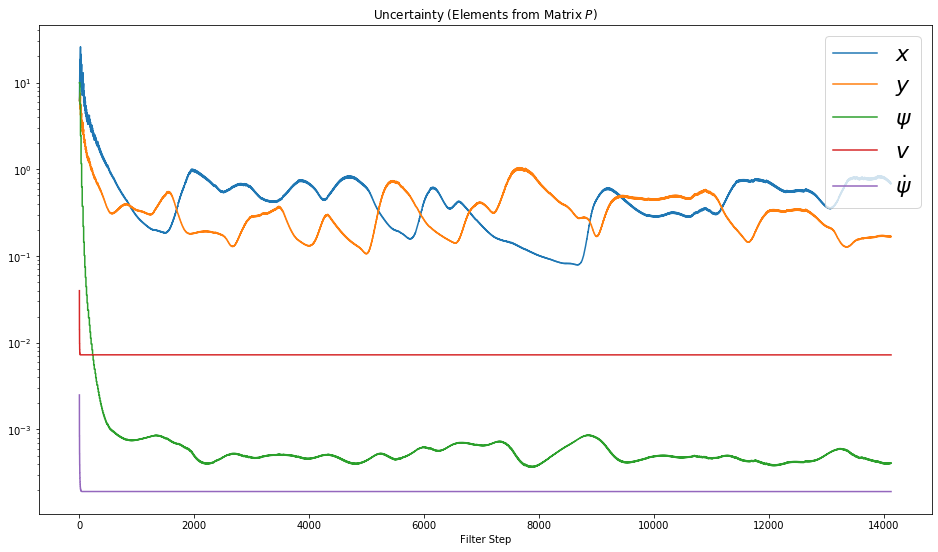

In [209]:
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m),Py, label='$y$')
plt.step(range(m),Ppsi, label='$\psi$')
plt.step(range(m),Pv, label='$v$')
plt.step(range(m),Pdpsi, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

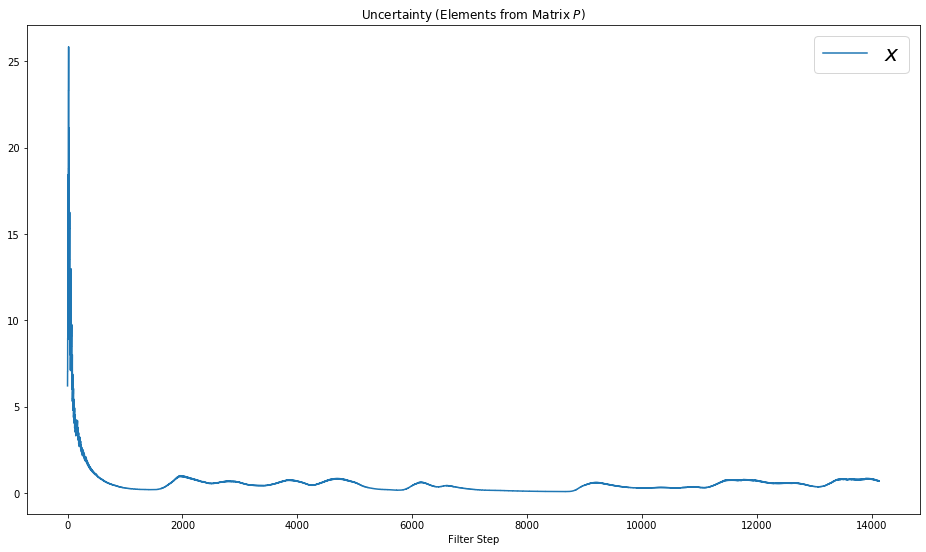

In [210]:
fig = plt.figure(figsize=(16,9))
#plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m),Px, label='$x$')
# plt.step(range(m),Py, label='$y$')
# plt.step(range(m),Ppsi, label='$\psi$')
# plt.step(range(m),Pv, label='$v$')
# plt.step(range(m),Pdpsi, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

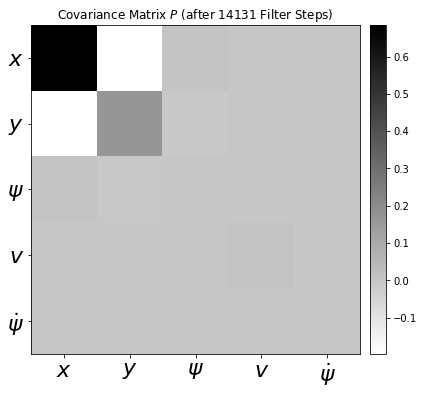

In [211]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filter Steps)' % (m))
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(6))
# set the locations and labels of the yticks
plt.yticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(6))
# set the locations and labels of the yticks
plt.xticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5,4.5])
plt.ylim([4.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

In [212]:
print(range(len(measurements[0])))
print(range(m))

range(0, 14131)
range(0, 14131)


### Innovations

In [213]:
from scipy import stats

print("Innovation x")
print(stats.describe(innov_x))
print("Innovation y")
print(stats.describe(innov_y))

Innovation x
DescribeResult(nobs=14131, minmax=(-6.400089345148846, 4.983582960635289), mean=0.303920235927091, variance=3.091077922019193, skewness=-0.43756441017347747, kurtosis=0.7043359625312493)
Innovation y
DescribeResult(nobs=14131, minmax=(-14.989663405079511, 6.9083869669753994), mean=-0.010433969143761953, variance=12.333568591503187, skewness=-1.7172431972172504, kurtosis=3.8040671600407316)


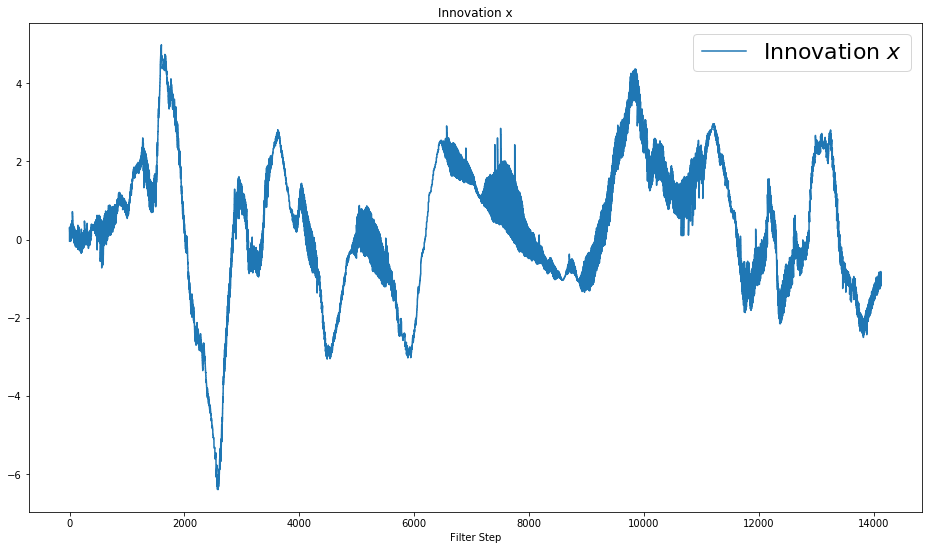

In [214]:
fig = plt.figure(figsize=(16,9))
#plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m), innov_x, label='Innovation $x$')
# plt.step(range(m),Py, label='$y$')
# plt.step(range(m),Ppsi, label='$\psi$')
# plt.step(range(m),Pv, label='$v$')
# plt.step(range(m),Pdpsi, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Innovation x')
plt.legend(loc='best',prop={'size':22})

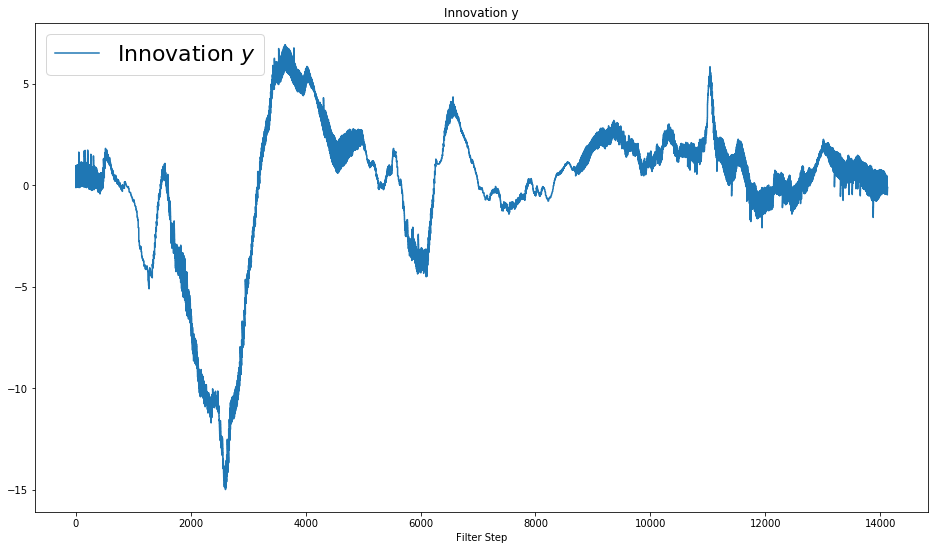

In [215]:
fig = plt.figure(figsize=(16,9))
#plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m), innov_y, label='Innovation $y$')
# plt.step(range(m),Py, label='$y$')
# plt.step(range(m),Ppsi, label='$\psi$')
# plt.step(range(m),Pv, label='$v$')
# plt.step(range(m),Pdpsi, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Innovation y')
plt.legend(loc='best',prop={'size':22})

### Kalman Gains

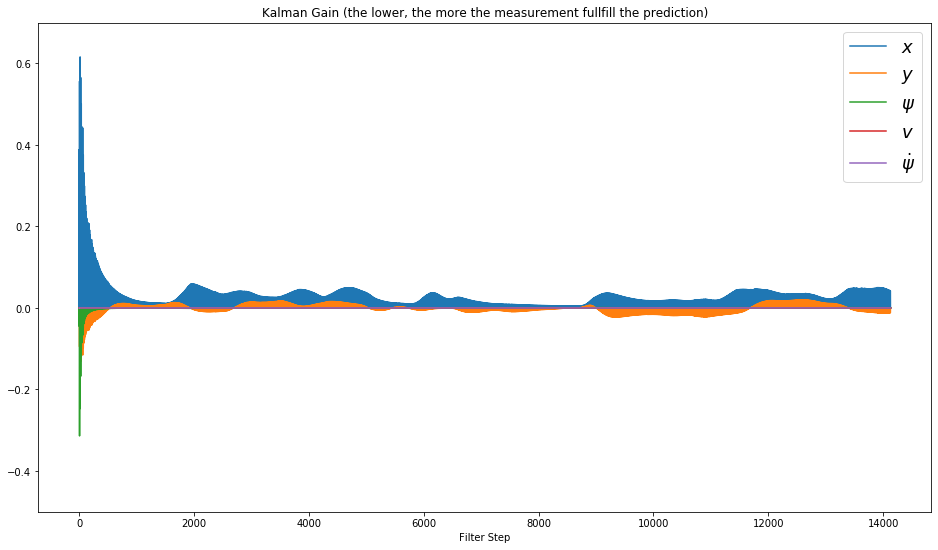

In [216]:
fig = plt.figure(figsize=(16,9))
plt.step(range(m),Kx, label='$x$')
plt.step(range(m),Ky, label='$y$')
plt.step(range(m),Kpsi, label='$\psi$')
plt.step(range(m),Kv, label='$v$')
plt.step(range(m),Kdpsi, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.50,0.70])
#plt.ylim([-1,1])

## State Vector

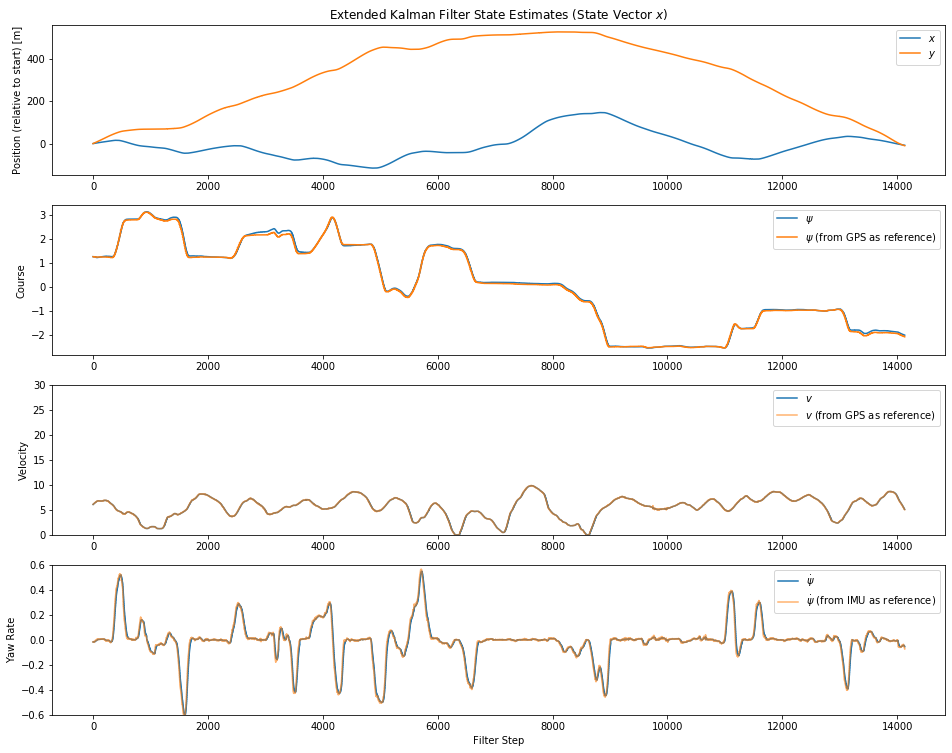

In [217]:
fig = plt.figure(figsize=(16,16))
plt.subplot(511)
plt.step(range(m),x0-mx[0], label='$x$')
plt.step(range(m),x1-my[0], label='$y$')

plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
plt.legend(loc='best')
plt.ylabel('Position (relative to start) [m]')

plt.subplot(512)
plt.step(range(m),x2, label='$\psi$')
#plt.step(range(m),(course+np.pi)%(2.0*np.pi) - np.pi, label='$\psi$ (from GPS as reference)')
plt.step(range(m),course, label='$\psi$ (from GPS as reference)')
plt.ylabel('Course')
plt.legend(loc='best')
           
plt.subplot(513)
plt.step(range(m),x3, label='$v$')
plt.step(range(m),speed, label='$v$ (from GPS as reference)', alpha=0.6)
plt.ylabel('Velocity')
plt.ylim([0, 30])
plt.legend(loc='best')

plt.subplot(514)
plt.step(range(m),x4, label='$\dot \psi$')
plt.step(range(m),yawrate, label='$\dot \psi$ (from IMU as reference)', alpha=0.6)
plt.ylabel('Yaw Rate')
plt.ylim([-0.6, 0.6])
plt.legend(loc='best')

plt.xlabel('Filter Step')

plt.savefig('Extended-Kalman-Filter-CTRA-State-Estimates.png', dpi=72, transparent=True, bbox_inches='tight')

## Position x/y

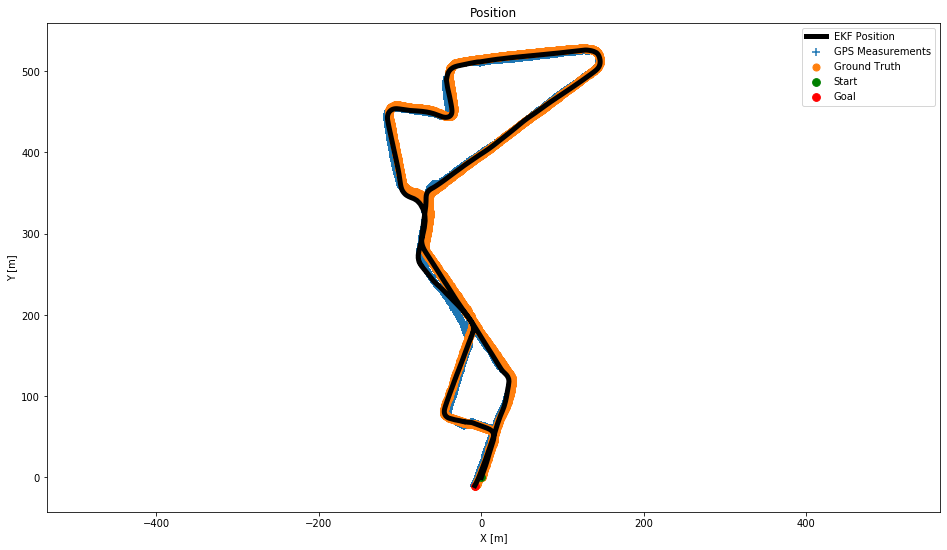

In [218]:
fig = plt.figure(figsize=(16,9))

# EKF State
plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(x0,x1, label='EKF Position', c='k', lw=5)

# Measurements
#plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', marker='+')
plt.scatter(mx,my, s=50, label='GPS Measurements', marker='+')
#cbar=plt.colorbar(ticks=np.arange(20))
#cbar.ax.set_ylabel(u'EPE', rotation=270)
#cbar.ax.set_xlabel(u'm')

# Ground Truth
#plt.scatter(mxGT[::5],myGT[::5], s=50, label='Ground Truth', marker='o')
plt.scatter(mxGT,myGT, s=50, label='Ground Truth', marker='o')

# Start/Goal
plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Position')
plt.legend(loc='best')
plt.axis('equal')
#plt.tight_layout()

#plt.savefig('Extended-Kalman-Filter-CTRA-Position.png', dpi=72, transparent=True, bbox_inches='tight')

### Detailed View

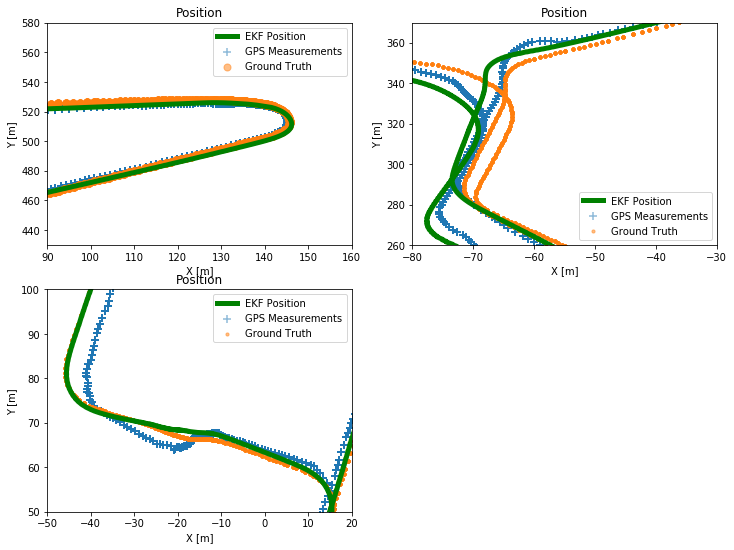

In [219]:
fig = plt.figure(figsize=(12,9))

plt.subplot(221)
# EKF State
#plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

# Measurements
plt.scatter(mx,my, s=50, label='GPS Measurements', alpha=0.5, marker='+')

#cbar=plt.colorbar(ticks=np.arange(20))
#cbar.ax.set_ylabel(u'EPE', rotation=270)
#cbar.ax.set_xlabel(u'm')

# Ground Truth
plt.scatter(mxGT,myGT, s=50, label='Ground Truth', alpha=0.5,marker='o')

plt.xlabel('X [m]')
plt.xlim(90, 160)
plt.ylabel('Y [m]')
plt.ylim(430, 580)
plt.title('Position')
plt.legend(loc='best')


plt.subplot(222)

# EKF State
plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=1.0, scale=1.0)
plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

# Measurements
plt.scatter(mx,my, s=50, label='GPS Measurements', alpha=0.5, marker='+')
#cbar=plt.colorbar(ticks=np.arange(20))
#cbar.ax.set_ylabel(u'EPE', rotation=270)
#cbar.ax.set_xlabel(u'm')

# Ground Truth
plt.scatter(mxGT,myGT, s=10, label='Ground Truth', alpha=0.5,marker='o')

plt.xlabel('X [m]')
plt.xlim(-80, -30)
plt.ylabel('Y [m]')
plt.ylim(260, 370)
plt.title('Position')
plt.legend(loc='best')


plt.subplot(223)

# EKF State
#plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

# Measurements
plt.scatter(mx,my, s=50, label='GPS Measurements', alpha=0.5, marker='+')
#cbar=plt.colorbar(ticks=np.arange(20))
#cbar.ax.set_ylabel(u'EPE', rotation=270)
#cbar.ax.set_xlabel(u'm')

# Ground Truth
plt.scatter(mxGT,myGT, s=10, label='Ground Truth', alpha=0.5,marker='o')

plt.xlabel('X [m]')
plt.xlim(-50, 20)
plt.ylabel('Y [m]')
plt.ylim(50, 100)
plt.title('Position')
plt.legend(loc='best')

# Gráficos de Erros

In [220]:
# Calcular a distância euclidiana entre as medições e o ground truth

# pos_x = np.asarray(x0p)
# pos_y = np.asarray(x1p)
# pos_mxGT = np.asarray(mxGTp)
# pos_myGT = np.asarray(myGTp)

de = np.sqrt((pos_x - pos_mxGT)**2 + (pos_y - pos_myGT)**2 )
#de = np.sqrt((x0p - mxGTp)**2 + (x1p - myGTp)**2 )
print(de[0:30], de.shape)


[0.         0.07480337 0.08635223 0.06834952 0.08199549 0.11070675
 0.18402063 0.29009589 0.3312452  0.35629843 0.36490173 0.3577796
 0.34644898 0.33689911 0.32292805 0.29368359 0.26822319 0.22725802
 0.19480913 0.15247478 0.1157377  0.1123537  0.10604457 0.13043402
 0.1462778  0.16456947 0.19043178 0.21580959 0.24506127 0.27921692] (1372,)


In [221]:
# Calcular a distância euclidiana entre as estimativas e o ground truth

#dm = np.sqrt((mx - mxGT)**2 + (my - myGT)**2 )
dm = np.sqrt((pos_mx - pos_mxGT)**2 + (pos_my - pos_myGT)**2 )
print(dm[0:30], dm.shape)

[0.         0.         0.00770476 0.02292918 0.048541   0.11398773
 0.23473931 0.33270566 0.30837399 0.30819063 0.27862247 0.23666522
 0.21590229 0.2279278  0.20859665 0.14524002 0.14585661 0.10095716
 0.10884136 0.11806124 0.21128227 0.24774943 0.23865224 0.23678098
 0.2657076  0.25672353 0.25415607 0.29603721 0.30886976 0.335074  ] (1372,)


Medição
DescribeResult(nobs=1372, minmax=(0.0, 21.458594761214222), mean=4.856536751521054, variance=16.872752430644663, skewness=2.001596377856917, kurtosis=3.877461348276638)
Estimação
DescribeResult(nobs=1372, minmax=(0.0, 15.557787656842716), mean=3.785218114052111, variance=10.704171504101518, skewness=1.739739627238605, kurtosis=3.1022630511979994)


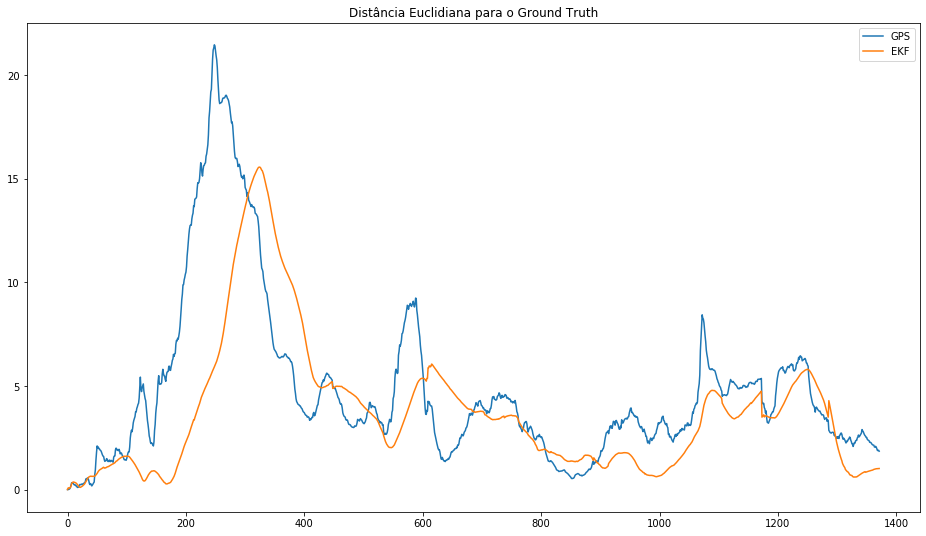

In [222]:
from scipy import stats

print("Medição")
print(stats.describe(dm))
print("Estimação")
print(stats.describe(de))

fig = plt.figure(figsize=(16,9))
plt.plot(dm, label='GPS')
plt.plot(de, label='EKF')
plt.title("Distância Euclidiana para o Ground Truth")
plt.legend(loc='best')

plt.savefig('Comparação Distâncias Euclidianas para o Ground Truth.png', dpi=72, transparent=True, bbox_inches='tight')


Medição
DescribeResult(nobs=1372, minmax=(0.0, 21.458594761214222), mean=4.856536751521054, variance=16.872752430644663, skewness=2.001596377856917, kurtosis=3.877461348276638)
Estimação
DescribeResult(nobs=1372, minmax=(0.0, 15.557787656842716), mean=3.785218114052111, variance=10.704171504101518, skewness=1.739739627238605, kurtosis=3.1022630511979994)


<Figure size 432x288 with 0 Axes>

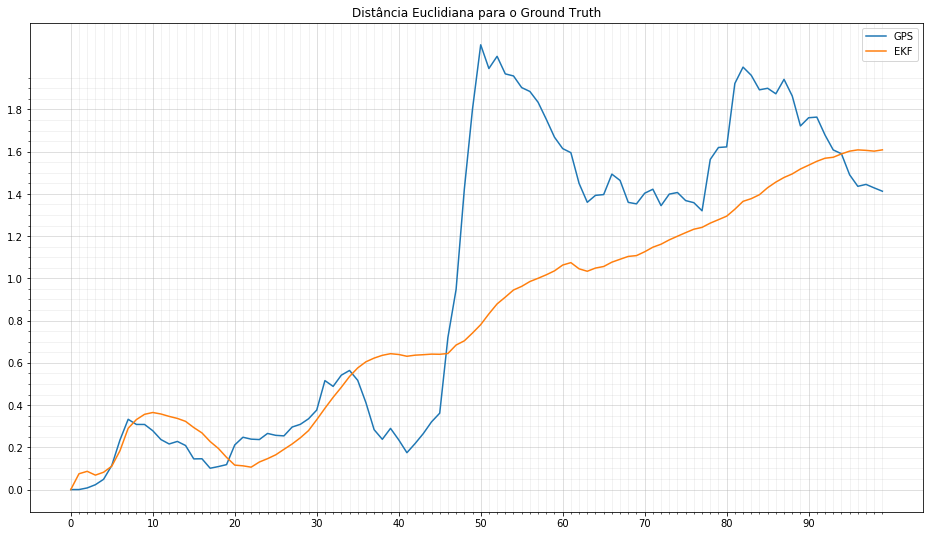

<Figure size 432x288 with 0 Axes>

In [223]:
from scipy import stats

print("Medição")
print(stats.describe(dm))
print("Estimação")
print(stats.describe(de))

fig = plt.figure(figsize=(16,9))

ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
y_major_ticks = np.arange(0, 2.0, 0.2)
y_minor_ticks = np.arange(0, 2.0, 0.05)
x_major_ticks = np.arange(0, 100, 10)
x_minor_ticks = np.arange(0, 100, 1)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)


plt.plot(dm[0:100], label='GPS')
plt.plot(de[0:100], label='EKF')
plt.title("Distância Euclidiana para o Ground Truth")
plt.legend(loc='best')
plt.figure()

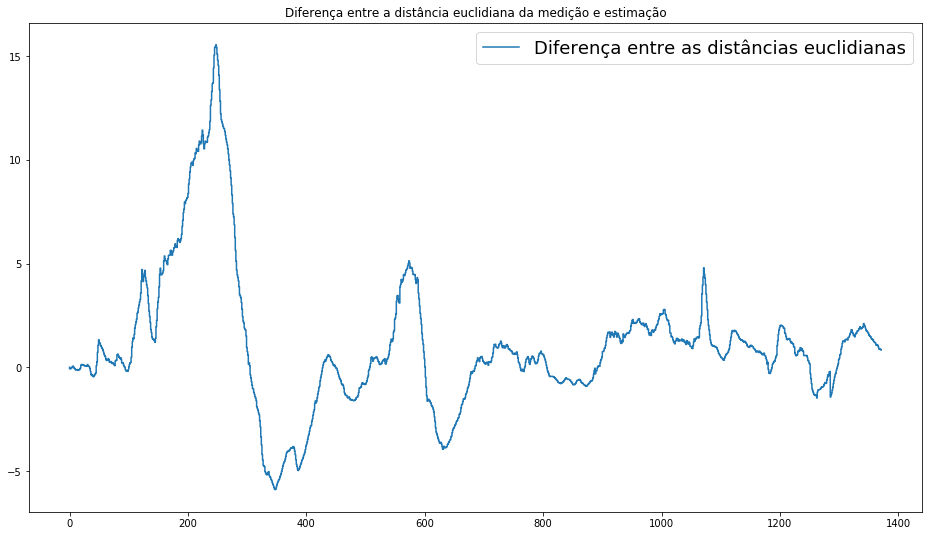

In [224]:
# Mostrar a diferença da distância euclidiana
err_de_dm = dm - de

fig = plt.figure(figsize=(16,9))
plt.step(range(len(err_de_dm)),err_de_dm, label="Diferença entre as distâncias euclidianas")
plt.title("Diferença entre a distância euclidiana da medição e estimação")
plt.legend(prop={'size':18})

Medição
DescribeResult(nobs=1372, minmax=(-8.138875291298085, 5.3184206494558595), mean=-1.39937814017006, variance=6.033079635480211, skewness=-0.2592613178101407, kurtosis=-0.11874930269755879)
Estimação
DescribeResult(nobs=1372, minmax=(-8.317903685871059, 1.5322158456276824), mean=-1.7100792868887373, variance=4.317186507170514, skewness=-1.076145848548453, kurtosis=0.9539544569719256)


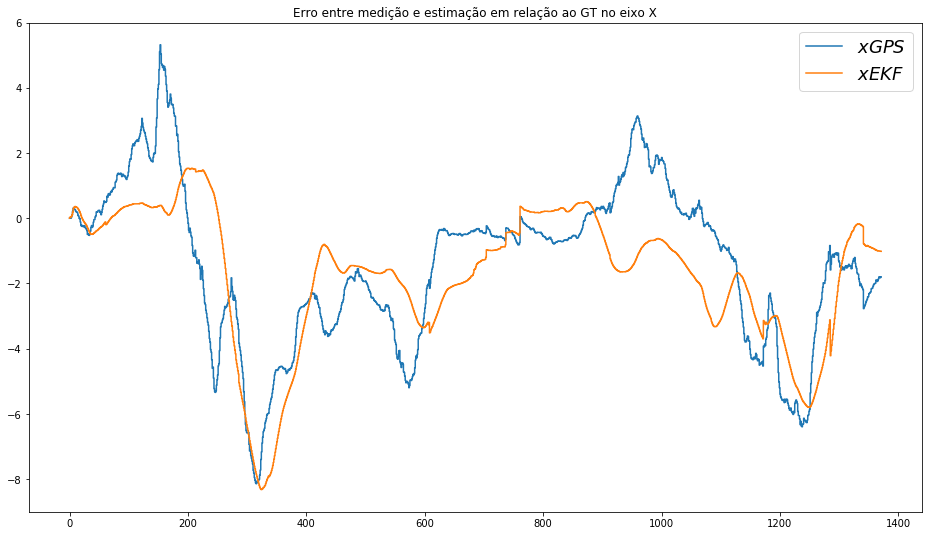

In [225]:
# Erro na medida (Eixo X)
#ErrxGPS = abs(pos_mx-mxGTp)
ErrxGPS = pos_mx-mxGTp
print("Medição")
print(stats.describe(ErrxGPS))

# Erro na estimativa (Eixo X)
ErrxEKF = pos_x-mxGTp
print("Estimação")
print(stats.describe(ErrxEKF))

fig = plt.figure(figsize=(16,9))
plt.step(range(len(mxp)),ErrxGPS, label='$xGPS$')
plt.step(range(len(mxp)),ErrxEKF, label='$xEKF$')
plt.title("Erro entre medição e estimação em relação ao GT no eixo X")
plt.legend(prop={'size':18})

In [226]:
# # Erro na medida (Eixo X)
# ErrxGPS = abs(Zx-mxGT)
# print("Medição")
# print(stats.describe(ErrxGPS))

# # Erro na estimativa (Eixo X)
# ErrxEKF = abs(x0-mxGT) 
# print("Estimação")
# print(stats.describe(ErrxEKF))

# fig = plt.figure(figsize=(16,9))
# plt.step(range(len(measurements[0])),ErrxGPS, label='$GPS$')
# plt.step(range(len(measurements[0])),ErrxEKF, label='$EKF$')
# plt.title("Erro entre medição e estimação em relação ao GT no eixo X")
# plt.legend(prop={'size':18})

Medição
DescribeResult(nobs=1372, minmax=(-20.796095349169633, 8.427825855723938), mean=-1.9651862069890653, variance=28.61836423662683, skewness=-1.3807792159068866, kurtosis=2.032735840833335)
Estimação
DescribeResult(nobs=1372, minmax=(-13.155861306808447, 3.506498292459355), mean=-1.9877690964197579, variance=13.84469967184733, skewness=-1.0696224908797773, kurtosis=0.8882162339906037)


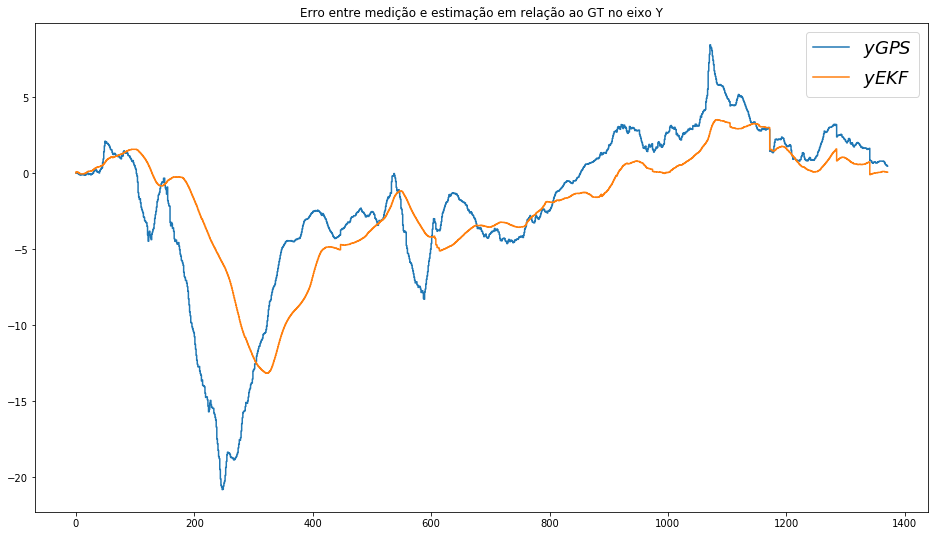

In [227]:
# Erro na medida (Latitude)
#ErryGPS = abs(pos_my-myGTp)
ErryGPS = pos_my-myGTp
print("Medição")
print(stats.describe(ErryGPS))

# Erro na estimativa (Latitude)
#ErryEKF = abs(pos_y-myGTp)
ErryEKF = pos_y-myGTp
print("Estimação")
print(stats.describe(ErryEKF))

fig = plt.figure(figsize=(16,9))
plt.step(range(len(mxp)),ErryGPS, label='$yGPS$')
plt.step(range(len(mxp)),ErryEKF, label='$yEKF$')
plt.title("Erro entre medição e estimação em relação ao GT no eixo Y")
plt.legend(prop={'size':18})

## Análises Complementares

In [228]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse(errors):
    return np.sqrt(((errors) ** 2).mean())

## Root Mean Square Error (RMSE)

In [229]:
# RMSE da distância euclidiana da estimação (erro entre o que foi estimado e o Ground Truth)
rmse_de = rmse(de)
print("RMSE to the Estimates: " + str(rmse_de))

rmse_dm = rmse(dm)
print("RMSE to the Measurements: " + str(rmse_dm))

RMSE to the Estimates: 5.002423992503595
RMSE to the Measurements: 6.359748715555293


In [230]:
from scipy import stats

print("Incerteza de x")
print(stats.describe(Px))
print("Incerteza de y")
print(stats.describe(Py))

Incerteza de x
DescribeResult(nobs=14131, minmax=(0.07900390527731567, 25.848108224928055), mean=0.5763391553959515, variance=0.99965016931005, skewness=11.558235512118241, kurtosis=176.72718018694374)
Incerteza de y
DescribeResult(nobs=14131, minmax=(0.10593404931358492, 7.585161818672311), mean=0.37381160278078734, variance=0.14041608994129484, skewness=8.982559372264141, kurtosis=120.22020968197755)


## Plotar o Heading

In [231]:
#mxGT[0:21], mx[0:21], x0[0:41]

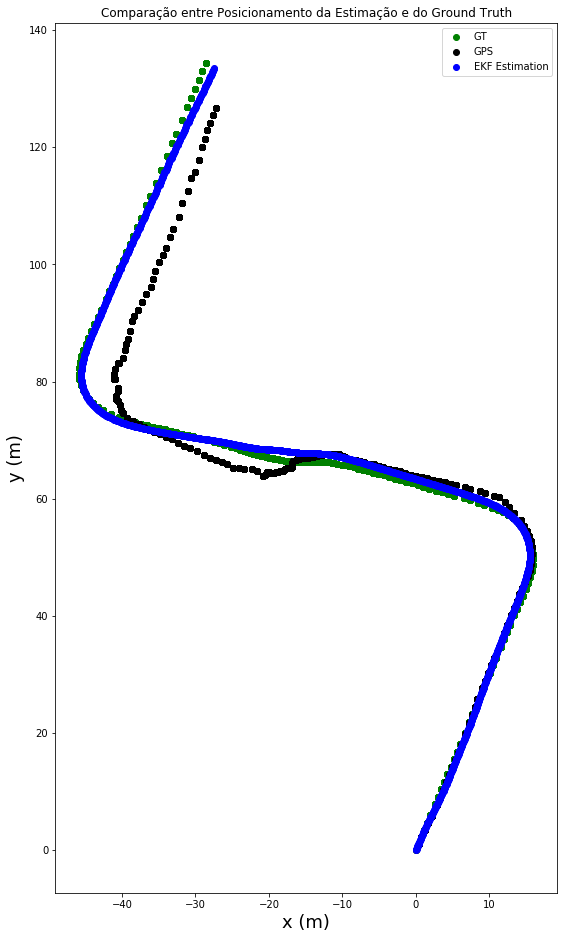

In [232]:
fig = plt.figure(figsize=(9,16))

ini = 0
lim = 2000
#lim = 13849

Ugt=np.cos(course)*speed
Vgt=np.sin(course)*speed
#plt.quiver(mxGT[ini:lim], myGT[ini:lim], Ugt[ini:lim], Vgt[ini:lim], color='#94C600', units='xy', width=0.05, scale=0.5)
plt.scatter(mxGT[ini:lim], myGT[ini:lim], label='GT', c='g', lw=1)
plt.scatter(mx[ini:lim], my[ini:lim], label='GPS', c='k', lw=1)

Ue=np.cos(x2)*x3
Ve=np.sin(x2)*x3
#plt.quiver(x0[ini:lim], x1[ini:lim], Ue[ini:lim], Ve[ini:lim], color='#94CCFF', units='xy', width=0.05, scale=0.5)
plt.scatter(x0[ini:lim], x1[ini:lim], label='EKF Estimation', c='b', lw=1)
plt.legend(loc='best')
plt.title("Comparação entre Posicionamento da Estimação e do Ground Truth")
plt.xlabel('x (m)', fontsize=18)
plt.ylabel('y (m)', fontsize=18)

plt.savefig('Comparação entre Posicionamento Estimação Ground Truth.png', dpi=72, transparent=True, bbox_inches='tight')

#plt.quiver(x0[ini:lim], x1[ini:lim], Ue[ini:lim], Ve[ini:lim], color='#94C600', units='xy', width=0.05, scale=0.5)


# U=float(np.cos(x[2])*x[3])
# V=float(np.sin(x[2])*x[3])

# # quiver plots a 2D field of arrows. X, Y define the arrow locations, U, V define the arrow directions.
# plt.quiver(x[0], x[1], U, V)
# plt.scatter(float(x[0]), float(x[1]), s=100)
# plt.title('Initial Location')
# plt.axis('equal')

# Acknowledgement

This work is based on https://github.com/balzer82/Kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb